<a href="https://colab.research.google.com/github/quantority/master-s-degree-projects/blob/main/AI_HW5_boosting_base_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашняя работа: прогнозирование заработной платы и кластеризация типов движений**

### **Постановка задачи:**

В этой работе две части:

*   В первой части вам предстоит построить алгоритм на основе бустинга для прогнозирования зарплаты
*   Во второй части вам предстоит кластеризовать типы движений по имеющимся данным с акселерометров и гироскопов

### **Оценивание:**

- Как всегда оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.
- Брать код из открытых источников позволительно. Следование культуре цитирования **обязательно.**

### **Баллы:**

Суммарно за задание можно получить 10 основных и 1 бонусный балл.

Оценка за ДЗ = min{ваш балл, 10}

**Мягкий дедлайн: 16 февраля 23:59**

**Интересной вам работы!**


# **Часть 1. Прогнозирование заработной платы при помощи бустинга**

**Количество баллов:** 7

## **Постановка задачи:**

Данные выгружены и лежат в файле `ds_salary.csv`. Вам доступны описания признаков и значения целевой переменной.

**Ваша задача:** построение модели бустинга и оценка данной модели.

## **Описание даных**

- work_year: год, в который взяты данные;
- experience_level: уровень опыта, кодируемый как SE, MI EN или EX
- employment_type: тип занятости (FT, PT, CT, FL)
- job_title: название рабочей позиции в компании;
- salary: зараплата на позиции;
- salary_currency: валюта в которой начисляют зарплату;
- employee_residence: страна или регион проживания сотрудника
- remote_ratio: процент удаленки, предлагаемый в компании (0, 50, 100)
- company_location: местоположение компании
- company_size: размер компании, оцененный как S, M, L
- salary_in_usd: целевая переменная


Как всегда, загрузим набор данных.

In [3]:
! pip install phik -q

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import phik
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor


In [5]:
df = pd.read_csv("https://github.com/hse-ds/iad-intro-ds/raw/refs/heads/master/2023/homeworks/hw-08-boosting/ds_salaries.csv")

## **Задание 1 (0.3 балла)**

Вам даны описания переменных. Проверьте, что категориальные признаки, категории которых перечислены, не имеют ошибочных значений. Для этого:

- Напишите цикл, пробегающий по выбранным признакам и оценивающий, что в них нет лишних значений;

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           3755 non-null   int64 
 1   experience_level    3755 non-null   object
 2   employment_type     3755 non-null   object
 3   job_title           3755 non-null   object
 4   salary              3755 non-null   int64 
 5   salary_currency     3755 non-null   object
 6   salary_in_usd       3755 non-null   int64 
 7   employee_residence  3755 non-null   object
 8   remote_ratio        3755 non-null   int64 
 9   company_location    3755 non-null   object
 10  company_size        3755 non-null   object
dtypes: int64(4), object(7)
memory usage: 322.8+ KB


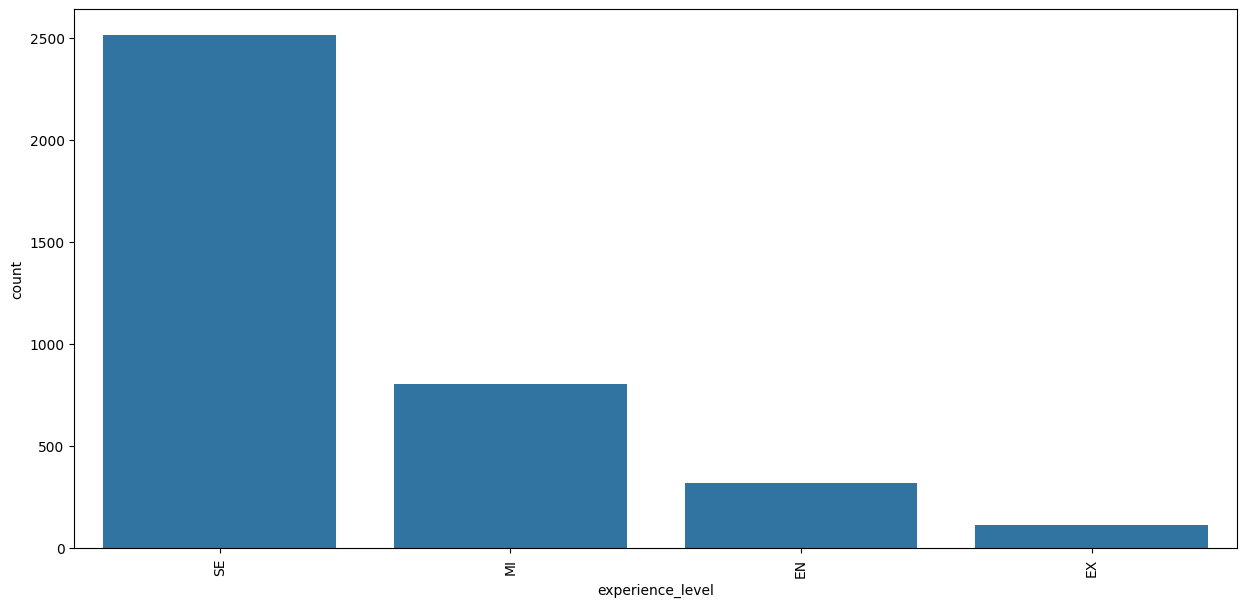

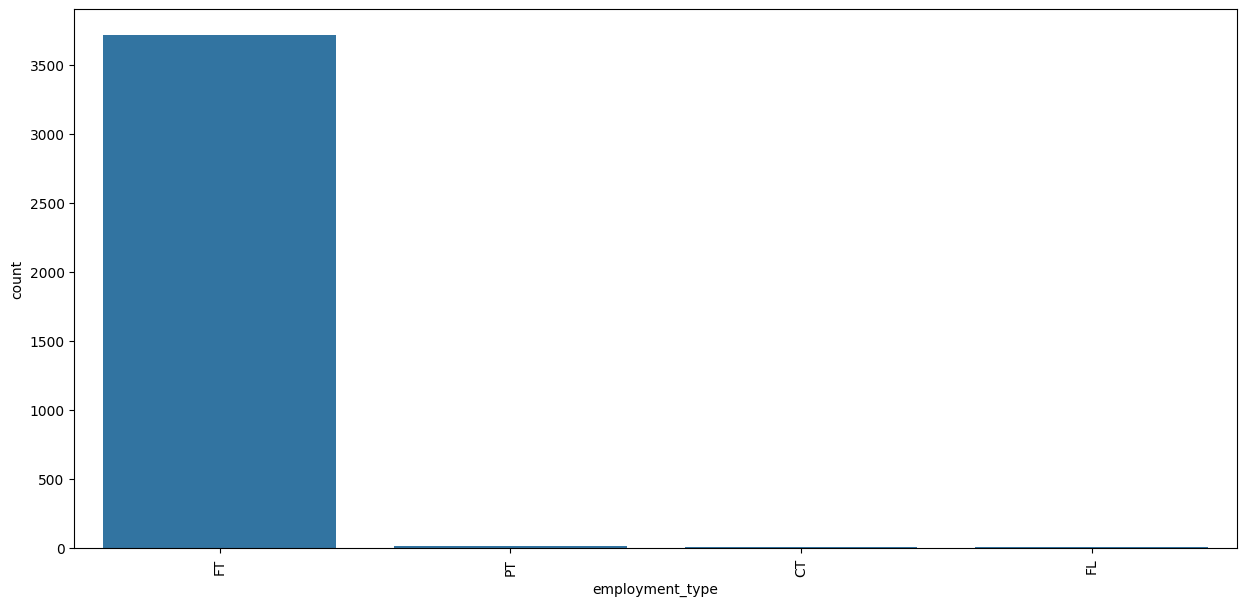

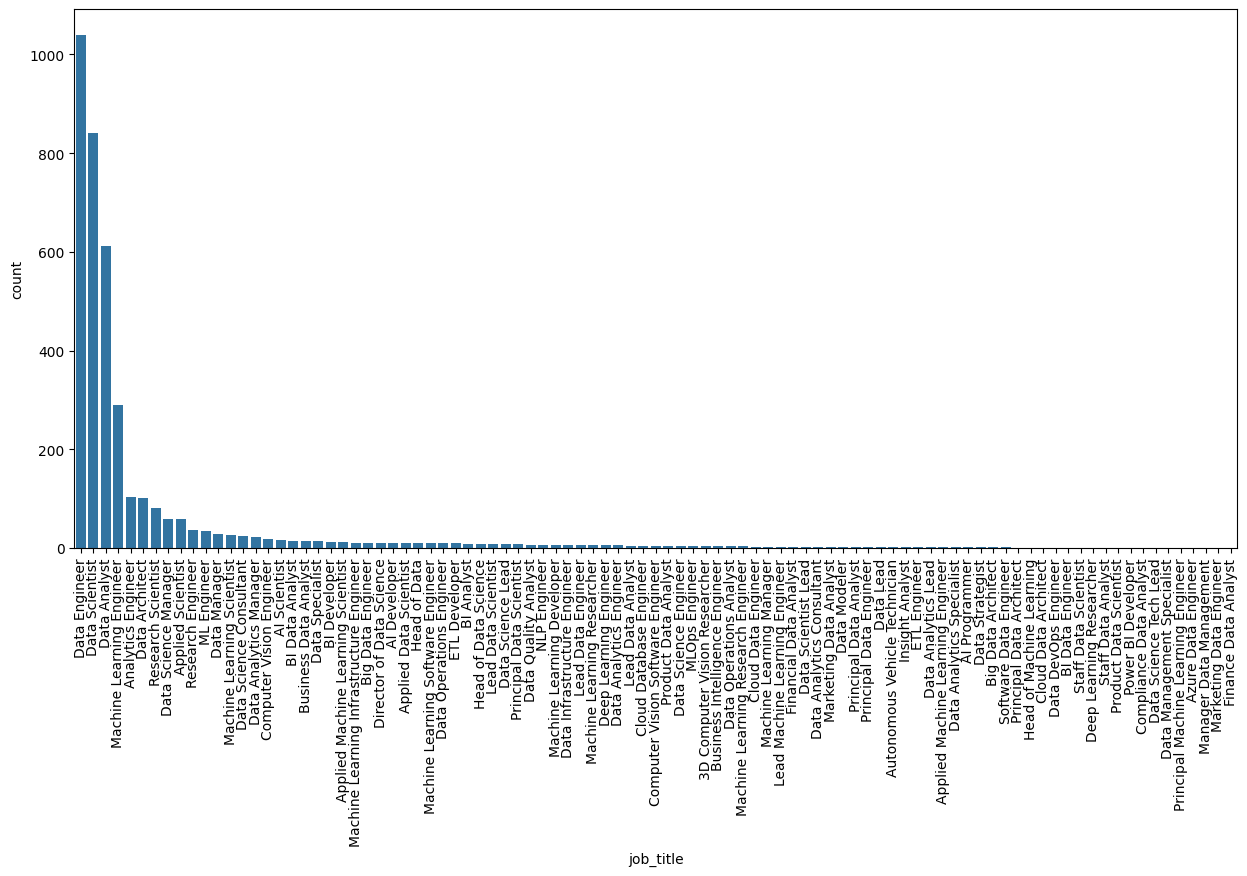

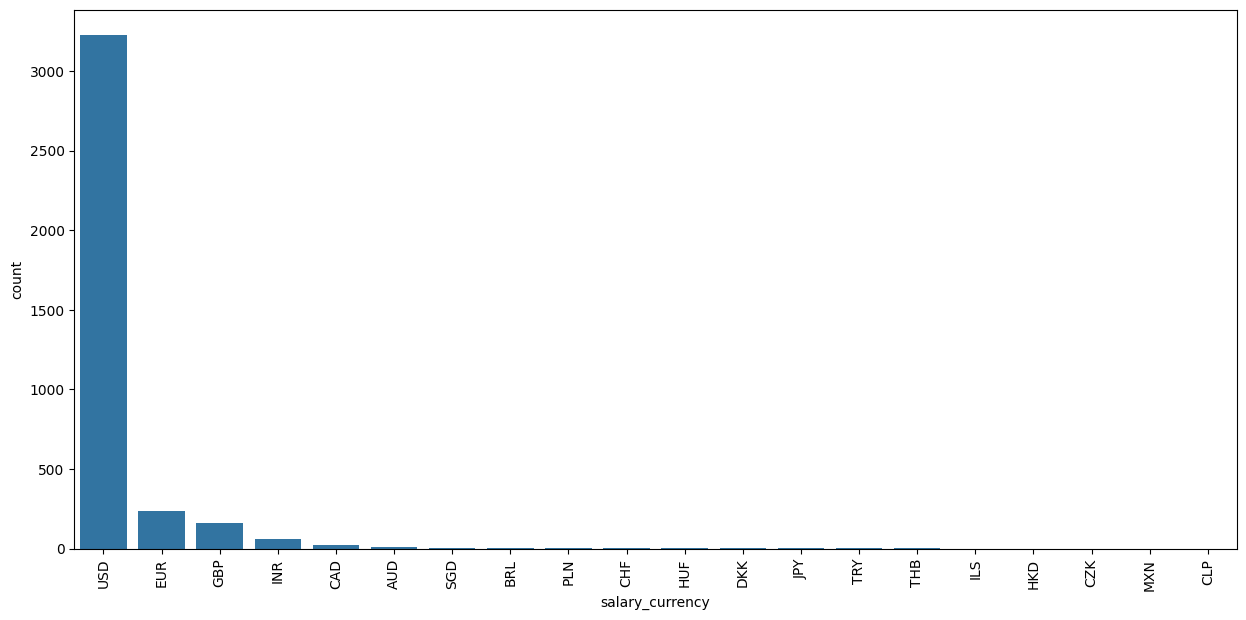

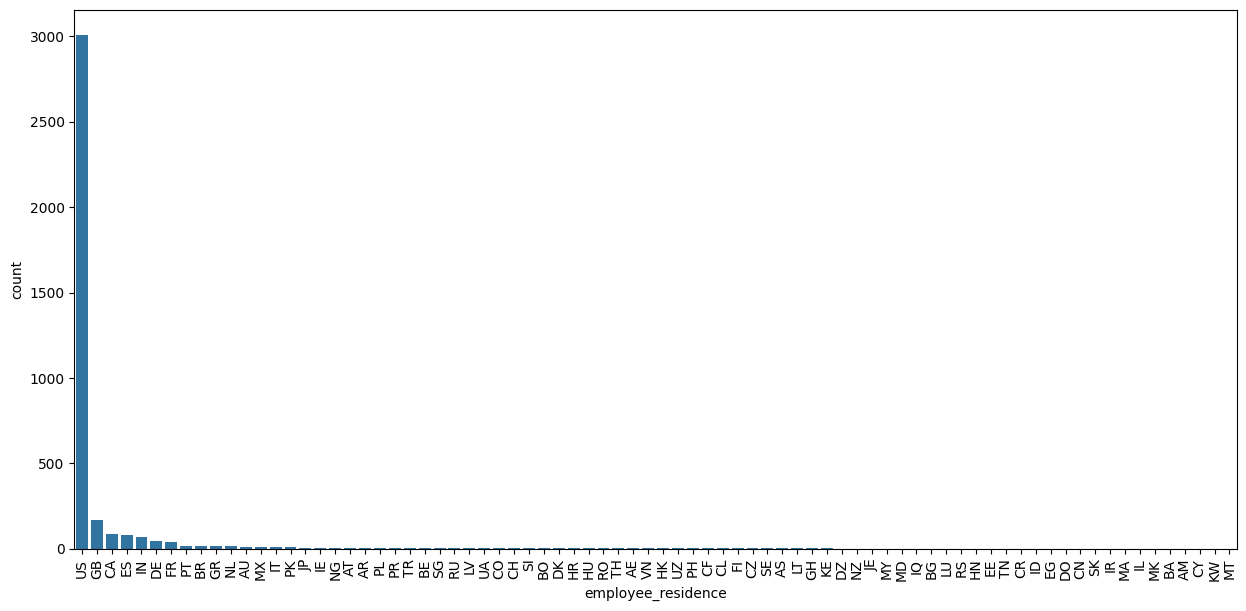

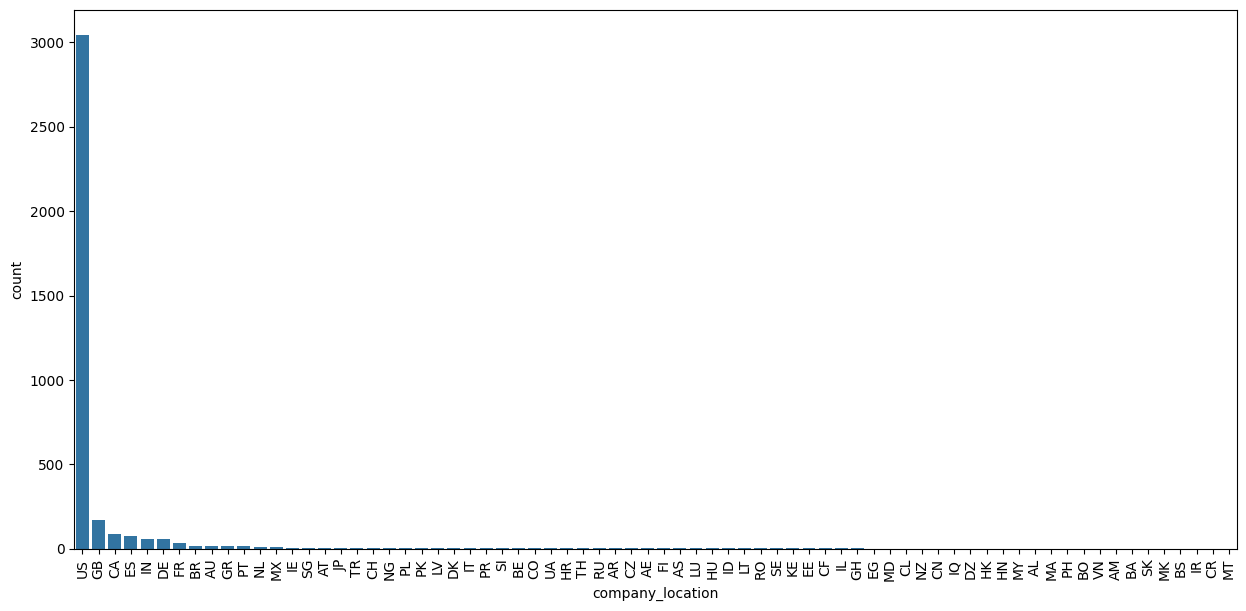

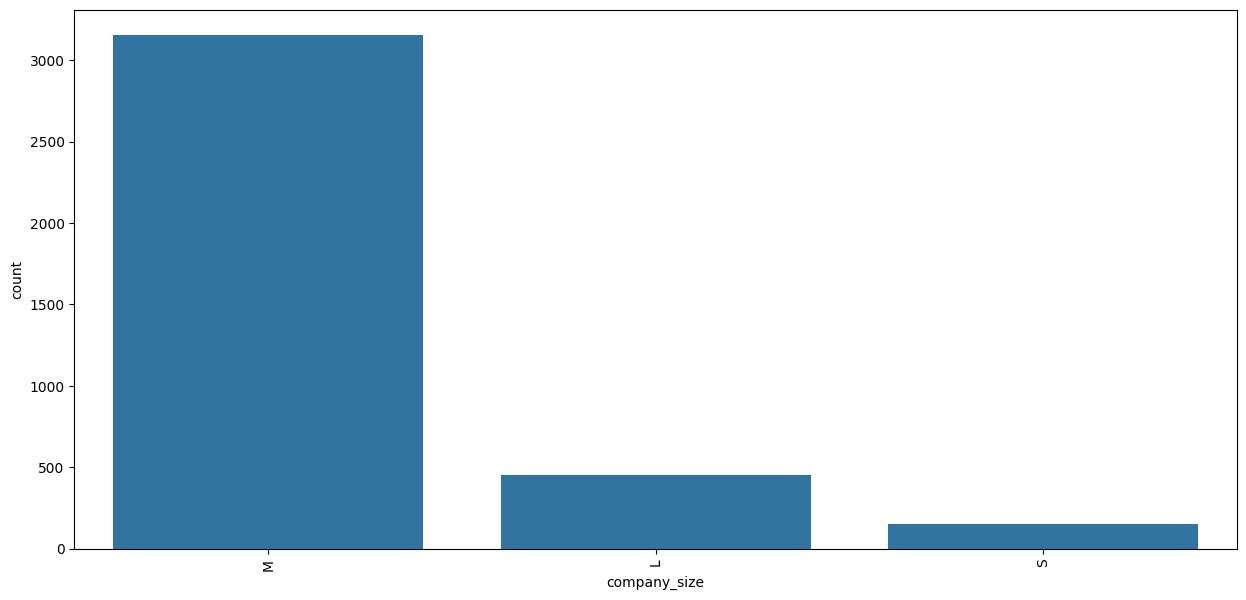

In [7]:
# Ваш код здесь

for col in df.select_dtypes(include=['object']).columns:
  plt.figure(figsize=(15, 7))
  sns.countplot(x=df[col], order=df[col].value_counts().index)
  plt.xticks(rotation=90)
  plt.show()

## **Задание 2 (0.3 балла)**

Проведите базовые шаги оценки качества данных.
- Есть есть проблемы, устраните их;
- Если нет проблем, кратко опишите это.

In [8]:
# Ваш код здесь
df.isna().sum()

,0
work_year,0
experience_level,0
employment_type,0
job_title,0
salary,0
salary_currency,0
salary_in_usd,0
employee_residence,0
remote_ratio,0
company_location,0


In [9]:
df[df.duplicated(keep=False) == True].sort_values(by=['job_title', 'salary', 'work_year'])

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
2920,2022,SE,FT,Analytics Engineer,63000,USD,63000,US,0,US,M
2945,2022,SE,FT,Analytics Engineer,63000,USD,63000,US,0,US,M
2697,2022,SE,FT,Analytics Engineer,110000,USD,110000,US,100,US,M
2738,2022,SE,FT,Analytics Engineer,110000,USD,110000,US,100,US,M
2696,2022,SE,FT,Analytics Engineer,130000,USD,130000,US,100,US,M
...,...,...,...,...,...,...,...,...,...,...,...
525,2023,SE,FT,Research Scientist,250000,USD,250000,US,0,US,M
956,2023,SE,FT,Research Scientist,250000,USD,250000,US,0,US,M
1751,2023,SE,FT,Research Scientist,250000,USD,250000,US,0,US,M
1247,2023,SE,FT,Research Scientist,253750,USD,253750,ES,0,ES,M


/usr/local/lib/python3.11/dist-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


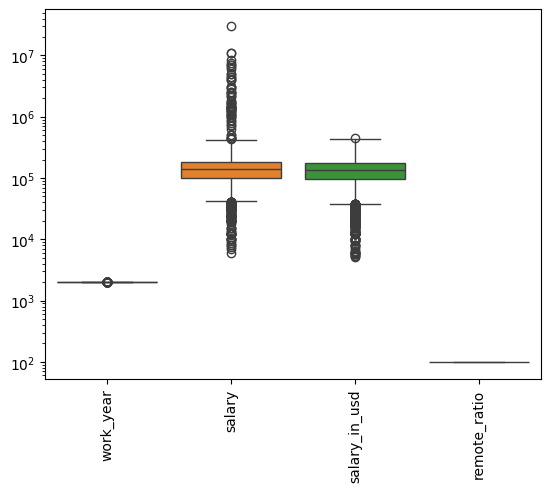

In [10]:
sns.boxplot(df.select_dtypes(include=['number']), log_scale=True)
plt.xticks(rotation=90)
plt.show()

In [11]:
df.describe()

,work_year,salary,salary_in_usd,remote_ratio
count,3755.000000,3.755000e+03,3755.000000,3755.000000
mean,2022.373635,1.906956e+05,137570.389880,46.271638
std,0.691448,6.716765e+05,63055.625278,48.589050
min,2020.000000,6.000000e+03,5132.000000,0.000000
25%,2022.000000,1.000000e+05,95000.000000,0.000000
50%,2022.000000,1.380000e+05,135000.000000,0.000000
75%,2023.000000,1.800000e+05,175000.000000,100.000000
max,2023.000000,3.040000e+07,450000.000000,100.000000


interval columns not set, guessing: ['work_year', 'salary', 'salary_in_usd', 'remote_ratio']


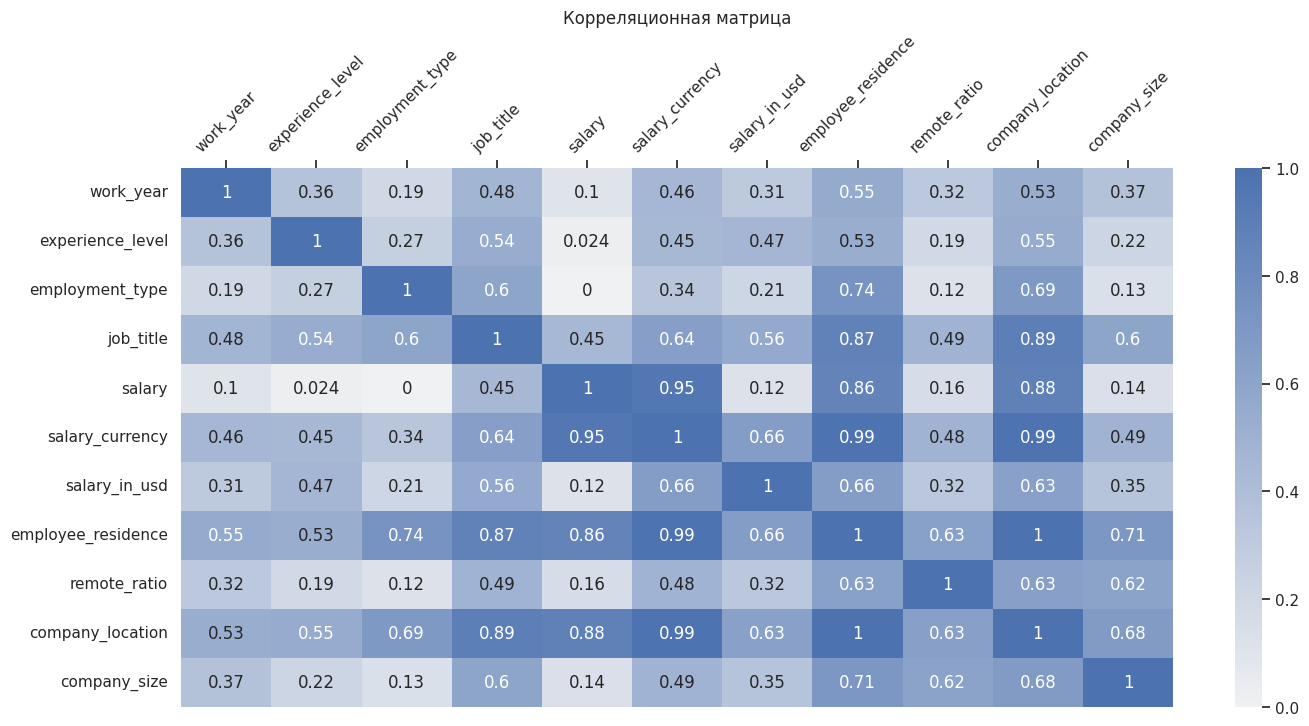

In [12]:
sns.set(rc = {'axes.facecolor':'#F5F5F5', 'figure.figsize':(16,7)}, font_scale = 1)
ax = sns.heatmap(data=df.phik_matrix(), annot=True, cmap=sns.color_palette("light:b", as_cmap=True))
ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()
plt.xticks(rotation=45)
plt.title('Корреляционная матрица')
plt.show()

## **Задание 3 (0.3 балла)**

Вернитесь к описанию признаков.
- Проверьте, все ли признаки соответствуют постановке задачи? Если есть лишние признаки, удалите их и обоснуйте удаление, если нет, сделайте вывод о релевантности (достаточно в одну-две строки)
- Зафиксируйте, в каких признаках много категорий.

In [13]:
# Ваш код здесь

df.drop(['salary', 'salary_currency', 'employee_residence'], axis=1, inplace=True)

Можно удалить заработную плату в валюте - у нас есть приведённая к долларовому эквиваленту, название валюты по той же причине и мне кажется место положение сотрудника никак не влияет на заработную плату, скорее имеет значение месторасположение компании, в которой сотрудник работает

## **Задание 4 (0.2 балла)**

Разделите выборку на train, test (80%, 20%).

In [14]:
# Ваш код здесь
y = df['salary_in_usd']
X = df.drop('salary_in_usd', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

## **Задание 5 (0.3 балла)**

Будем проверять два сценария. Первый — построение модели только на непрерывных признаках, а второй — построение с категориальными. В этом задании подготовьте всё, чтобы проверить валидность обоих сценариев. А именно:

- Выделите данные для тренировки и теста для непрерывных признаков
- Выделите данные для тренировки и теста для непрерывных + категориальных признаков, пока ничего не кодируйте.

In [15]:
# Ваш код здесь

X_train_cont = X_train.select_dtypes(include=['number'])

X_test_cont = X_test.select_dtypes(include=['number'])

## **Задание 6 (0.2 балла)**

- Обучите модель линейной регресии на числовых признаках и оцените её качество через mape и rmse;
- Сделайте вывод о качестве построенной модели;

In [16]:
# Ваш код здесь

lr = LinearRegression()
lr.fit(X_train_cont, y_train)

y_pred_lr_cont = lr.predict(X_test_cont)

rmse_lr_cont = np.sqrt(mean_squared_error(y_test, y_pred_lr_cont))

mape_lr_cont = mean_absolute_percentage_error(y_test, y_pred_lr_cont)

print('RMSE:', rmse_lr_cont)
print('MAPE:', mape_lr_cont)

RMSE: 61358.93909117817
MAPE: 0.706483138102007


In [25]:
scaler = StandardScaler()

X_train_cont_scaler = scaler.fit_transform(X_train_cont)

X_test_cont_scaler = scaler.transform(X_test_cont)

In [22]:
lr.coef_

array([2.10261208e+04, 3.33701610e-01])

In [19]:
X_test_cont

,work_year,remote_ratio
2148,2022,100
1044,2023,100
3321,2022,100
439,2023,0
3519,2021,50
...,...,...
2403,2022,0
2897,2022,100
612,2023,100
2677,2022,0


Модель так себе, в среднем она смещает предсказанные значения от фактических на 70%

## **Задание 8 (0.2 балла)**

- Обучите модель бустинга (любую из трех библиотек catboost, xgboost, lightgbm) с гиперпараметрами по умолчанию на непрерывных признаках и оцените её качество через mape и rmse;
- Сделайте вывод о качестве построенной модели;

In [18]:
# Ваш код здесь

lgbm = LGBMRegressor()
lgbm.fit(X_train_cont, y_train)

y_pred_lgbm_cont = lgbm.predict(X_test_cont)

rmse_lgbm_cont = np.sqrt(mean_squared_error(y_test, y_pred_lgbm_cont))

mape_lgbm_cont = mean_absolute_percentage_error(y_test, y_pred_lgbm_cont)

print('RMSE:', rmse_lgbm_cont)
print('MAPE:', mape_lgbm_cont)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000966 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8
[LightGBM] [Info] Number of data points in the train set: 3004, number of used features: 2
[LightGBM] [Info] Start training from score 138055.989348
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

## **Задание 9 (0.8 балла)**

Теперь подключим категориальные признаки. Но попроубем разные стратегии предобработки.

**1:**
- Предобработайте категориальные признаки при помощи OHE
- Постройте модель бустинга и линейную регрессию
- Оцените качество обеих моделей

**2:**
- Предобработайте категориальные признаки при помощи LabelEncoding
- Постройте модель бустинга и линейную регрессию
- Оцените качество обеих моделей

**3:**
- Предобработайте категориальные признаки при помощи MeanTargetEnc
- Постройте модель бустинга и линейную регрессию
- Оцените качество обеих моделей

Сделайте выводы по построениям 1-3. Выберите лучшую модель и дальше поработайте с ней.

In [ ]:
# Ваш код здесь

## **Задание 10 (0.5 балла)**

Покажите, где ошибается ваша модель. Выведите топ 20 примеров с наибольшей ошибкой. Проанализируйте их. Какие выводы можно сделать? Что стоит изменить в данных чтобы улучшить качество модели?

In [ ]:
# Ваш код здесь

**Ваш ответ здесь**.

## **Задание 11 (0.5 балла)**

Придумайте признаки для улучшения качества модели на основе предыдущего пункта. Как вам кажется какими признаками можно улучшить качетсво модели? Реализуйте признаки и проверьте улучшилось ли качество модели.

**Примечание:**
Полный балл за задание ставится даже при отсутствии улучшения качества модели, важно попробовать проверить свои гипотезы и сделать выводы.

In [ ]:
# Ваш код здесь

**Ваш ответ здесь**.

## **Задание 12 (1 балл)**

Поупражняемся с разными бустингами!

- Используйте catboost.
- Обучите модель — на полном наборе данных с категориальными признаками.
- Подберите оптимальные гиперпараметры.
- Оцените качество итоговой модели, скорость обучения и скорость предсказания.


**Примечание:**
Замерять скорость = смотреть, как долго исполняется код.

## **Задание 13 (1 балл)**

- Используйте xgboost.
- Обучите модель — на полном наборе данных с категориальными признаками. Стратегию кодирования оставьте ту, что показала себя лучшей в пункте 9.
- Подберите оптимальные гиперпараметры.
- Оцените качество итоговой модели, скорость обучения и скорость предсказания.



## **Задание 14 (1 балл)**

- Используйте lgbm.
- Обучите модель — на полном наборе данных с категориальными признаками. Стратегию кодирования оставьте ту, что показала себя лучшей в пункте 9.
- Подберите оптимальные гиперпараметры.
- Оцените качество итоговой модели, скорость обучения и скорость предсказания.


## **Задание 15 (0.4 балла)**

Сделайте выводы про модели и решение задачи.

- Какая из моделей показала лучший результат по качеству?
- Какая из моделей показала лучший результат по качеству, скорости обучения и скорости предсказания в совокупности?
- Насколько бустинги превзошли линейную модель? Целесообразно ли их использование?

# **Часть 2: кластеризация типов движений**
**Количество баллов:** 3

В этой части будем работать с набором данных Samsung Human Activity Recognition. Набор данных заранее предобработан и снова доступен вам по [ссылке](https://drive.google.com/file/d/16ISu7lMumt5rbticbOggHMRjwTGBETtO/view?usp=sharing).

### **Постановка задачи**
Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S2. Вид активности человека с телефоном в кармане известен:
- 1 - ходьба,
- 2 - подъем вверх по лестнице,
- 3 - спуск по лестнице,
- 4 - сидение,
- 5 - стояние,
- 6 - лежание


Представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков.

In [ ]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt


plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

%matplotlib inline
%config InlineBackend.figure_format="retina"

RANDOM_STATE = 42

### **Задание 16 (0.1 балл)**
Прочитайте данные из файлов и объедните тестовую и обучающие выборки.

В файлах ```..._labels``` лежат настоящие классы. Их также объедините, но в отдельную переменную (например ```y```). Данный вектор для кластеризации нам не нужен, но мы будем смотреть по нему метрики.

In [ ]:
# Ваш код здесь
X =
y =

In [ ]:
# убедимся, что y содержит нужные нам классы
np.unique(y)

### **Задание 17 (0.2 балла)**

Так как мы будем пользоваться метрическими алгоритмами, отмасштабируйте выборку с помощью ```StandardScaler```.

In [ ]:
# Ваш код здесь
scaler =
X_scaled =

### **Задание 18 (0.5 балла)**

Данных много и размерность большая. Чтобы ускорить рещение задачи с точки зрения построения модели, мы используем методы **понижения размерности**.

- Понизьте размерность с помощью `PCA`, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии отмасштабированных данных. Вам пригодится [документация](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

**Примечание:**
Для этого сумма значений массива pca.explained_variance_ratio_ должна быть не меньше 0.9.  ```random_state``` используйте из объявленной в самом начале переменной ```RANDOM_STATE``` (42).

In [ ]:
# Ваш код здесь
pca =
X_pca =

### **Задание 19 (0.2 балла)**

Визуализируйте данные в проекции на первые две главные компоненты. Используйте ```cmap="virdis"``` или любой другой, с которым будет красиво!

Можете раскрасить кластеры.

In [ ]:
# Ваш код здесь
plt.scatter()

### **Задание 19. (0.5 балла)**

Разберёмся с `KMeans`, [doc](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

- Сделайте кластеризацию данных методом `KMeans`, обучив модель на данных со сниженной за счет `PCA` размерностью. Нужно искать 6 кластеров (изначально у нас 6 классов). Засеките время обучения и время инференса.

**Параметры обучения:**

```n_clusters = 6``` (число уникальных меток целевого класса = 6)

```n_init = 100```

```random_state = RANDOM_STATE``` (для воспроизводимости результата, не забывайте указывать его и дальше!)

In [ ]:
# Ваш код здесь

### **Задание 20 (0.2 балла)**

- Визуализируйте данные в проекции на первые две главные компоненты.
- Раскрасьте точки в соответствии с полученными метками кластеров.

In [ ]:
# Ваш код здесь

### **Задание 21 (0.3 балла)**

- Выберите какие-то метрики (минимум две) из известных вам. Объясните свой выбор
- Выведите на экран значения метрик качества, сделайте вывод о них и используйте их далее.

In [ ]:
# Ваш код здесь

**Ваш вывод здесь**

### **Задание 22 (0.7 баллов)**

Теперь попробуем сделать кластеризацию с помощью `AgglomerativeClustering`, [doc](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)

- Засеките время обучения и время инференса. После кластеризации также:
  - Вновь визуализируйте данные с раскраской по полученным меткам
  - Выведите метрики. Засеките время обучения и время инференса. Сравните с ```KMeans```.

Ответьте на следующие вопросы:
* Стало ли лучше?
* Почему?

In [ ]:
# Ваш код здесь

**Ваш вывод здесь**

### **Задание 23 (0.3 балла)**
Для самой успешной из полученных кластеризаций попробуйте дать интерпретацию кластеров. Опишите характеристики объектов, попавших в каждый кластер. Для этого можете ответить на следующие вопросы:

* Похожи ли объекты внутри каждого кластера на определенный тип активности человека?
* В каких кластерах смешано несколько типов активности? С чем, на ваш взгляд, это может быть связано?
* Качественная ли получилась кластеризация? На основании чего вы можете сделать такой вывод?

**Ваш вывод здесь**

## **Бонус-задание (1 балл)**
![RedPanda](http://imgur.com/6Aa52Lm.png)

Алгоритмы кластеризации могут применяться в самых разных задачах. Например, в анализе изображений есть задача разделения изображения на семантические компоненты, которую можно решать в том числе с помощью алгоритмов кластеризации. В бонусе предлагаем вам попрактиковаться именно в этом на чудесной утке и совах (```duck.jpg``` и ```owls.jpg```)

### **(0.1 балл)**

- Откройте изображения, после чего визуализируйте их с помощью ```plt.imshow()```

In [ ]:
from PIL import Image
# or
#import cv2

### **(0.4 балла)**

Для каждого изображения, используя кластеризацию ```KMeans```, выделите компоненты, охарактеризовав каждый пиксель следующим образом: $$\psi_i = [\lambda x_i, \lambda y_i, r_i, g_i, b_i]$$
 где
- $x_i$ и $y_i$ — координаты пикселя,
- $r_i, g_i, b_i$ — его цвет,
- $\lambda$ — параметр, выражающий важность пространственной связности перед цветовой похожестью.

Примените полученную функцию, взяв следующие $\lambda$: 0.3 и 1.5 для ```duck.jpg``` и ```owls.jpg``` (или другие, но тогда с вас красивые результаты :) )

**Примечание:**
Число кластеров подберите разумным образом на свой вкус (в качестве нулевого приближения можно взять 3)

In [ ]:
def find_components(image, lmbd, n_clusters):
    #your code here

### **(0.4 балла)**

Попробуйте выделить сегменты при помощи [спектральной кластеризации](http://scikit-learn.org/stable/modules/clustering.html#spectral-clustering). Обратите внимание на [пример в sklearn](http://scikit-learn.org/0.16/auto_examples/cluster/plot_lena_segmentation.html).


**Примечание:**

Для ускорения работы алгоритма рекомендуется привести изображение к серому цвету. При необходимости можно сжать изображения в 2 раза.

**Подсказка:**```skimage``` с его ```color``` и ```transform``` в этом помогут :)

Или же воспользуйтесь аналогичными средствами ```PIL``` или ```cv2```

In [ ]:
def spectral_segmentation(image, n_clusters, beta, eps):
    #your code here

### **(0.1 балл)**
Визуализируйте результаты сегментации (аналогично рисунку в начале задания 2) для обоих методов.

**Спасибо! Вы — человек — большой трудяга!**

Успокоительный котобонус :)

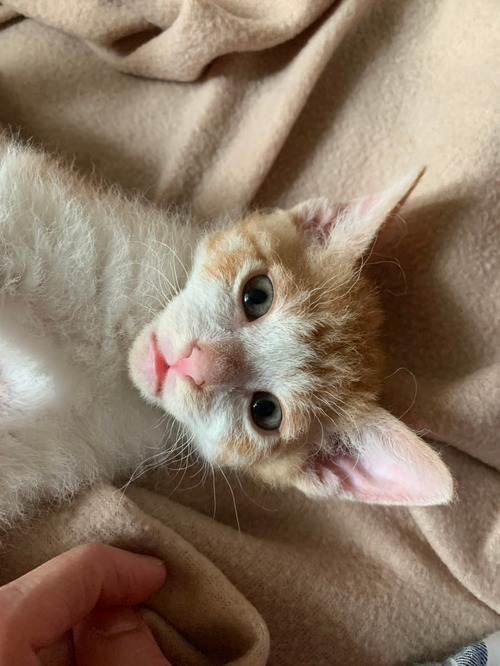